#Bibliotecas

In [239]:
#importamos bibliotecas que nos puedan ser de ayuda
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para el análisis de Series de Tiempo y Modelos de Pronóstico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm

# Suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline

#1. Construccion de una serie de Tiempo

In [283]:
url='https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Eval1/data/co2_spo_DailyData.txt'
my_cols_orig = ['0','year','month','day','hour','minute','second','1','CO2','2','3','4','5','6','7','8','9']
df_orig= pd.read_csv(url,names=my_cols_orig,encoding='cp1251',sep='\s+',header=None,skiprows=151,engine='python')
#print(df_orig)
df_2=df_orig.copy()
#Cambiamos los datos tipo fecha

df_2['Fecha']=pd.to_datetime(dict(day=df_2['day'],
                                  month=df_2['month'],
                                  year=df_2['year']),
                             dayfirst=True)
#Parecer ser que le valio el formato de fecha
df_2.head()

#Cambiamos los -999.99 por NaN 
str_Nan=-999.99
df_work00=df_2.replace(to_replace=str_Nan,value='NaN',regex=True)
#df_work00['CO2']
#Ya quedaron sustituidas


#recortamos el periodo de principios de 1980 a 2019
df_work0=df_work00[(df_work00['year']>=1980)& (df_work00['year']<=2019)]
#print(df_work0.head())
#print(df_work0.tail())



#Creamos el data frame que tenga solo las dos columnas que nos interesan
df_work1=df_work0[['Fecha','CO2']]
df_work1.head()

#Hacemos que el indice sea la fecha
df_work1= df_work1.set_index('Fecha')
df_work1.head()

#Se menciona que podemos usar la funcion para rellenar hacia enfrente los 
#valores vacios en base al ultimo valor anterior posible

df_work1.ffill(axis=0,inplace=True)
#Ahora solo convertimos los datos a numeros flotantes
df_work1['CO2']=pd.to_numeric(df_work1['CO2'],errors='coerce')

#Listo!!!! ahora hacemos el dataframe pedido y comprobamos
ts_test=df_work1.copy()
ts_test.ffill(axis=0,inplace=True)
ts_test.info()
print(ts_test.head())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14610 entries, 1980-01-01 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CO2     14610 non-null  float64
dtypes: float64(1)
memory usage: 228.3 KB
               CO2
Fecha             
1980-01-01  336.30
1980-01-02  336.28
1980-01-03  336.21
1980-01-04  336.19
1980-01-05  336.20


#Nuestro data frame resultante es ts_test




#2.Analisis de la serie de tiempo

In [289]:
#Creamos una funcion para probar la estacionaridad de la serie de tiempo
def test_stationarity(df_ts):
  #Determina la estadistica de promedios moviles
  rolmean = df_ts.rolling(window=365,center=True).mean()
  rolstd= df_ts.rolling(window=365,center=True).std()

  #Define el tamaño de la figura 
  plt.rcParams['figure.figsize']=(12,6)
  #Graficando las estadisticas de los promedios moviles
  plt.plot(df_ts,color='cyan',label='Original')
  plt.plot(rolmean,color='red',label='Rolling mean')
  plt.plot(rolstd,color='green',label='Rolling std deviation')

  plt.legend(loc='best')
  plt.title('Promedio movil y desviacion estandar')
  plt.grid()
  plt.show()

  #Realizara la prueba aumentada de dickey -fuller
  print('Resultados de la prueba de Dickey-Fuller: ')
  dftest = adfuller(df_ts , autolag='AIC')
  dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','p-value',
                                          '#Lags Used','Number of Observatons Used'])
  for key, value in dftest[4].items():
    dfoutput['Critical Value(%s)'%key]= value
  print(dfoutput)

  ##SE LO QUE SIGNIFICA LOS 4 Y DE 0:4 pero el tiempo no me alcanza para corregirlo

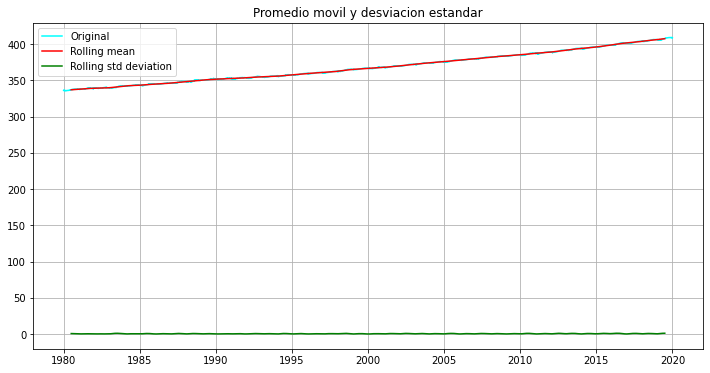

Resultados de la prueba de Dickey-Fuller: 
Test Statistic                    0.973933
p-value                           0.993983
#Lags Used                       42.000000
Number of Observatons Used    14567.000000
Critical Value(1%)               -3.430799
Critical Value(5%)               -2.861738
Critical Value(10%)              -2.566876
dtype: float64


In [290]:
#PROBAMOS ESTACIONARIDAD
#ts_test.head()

test_stationarity(ts_test['CO2'])

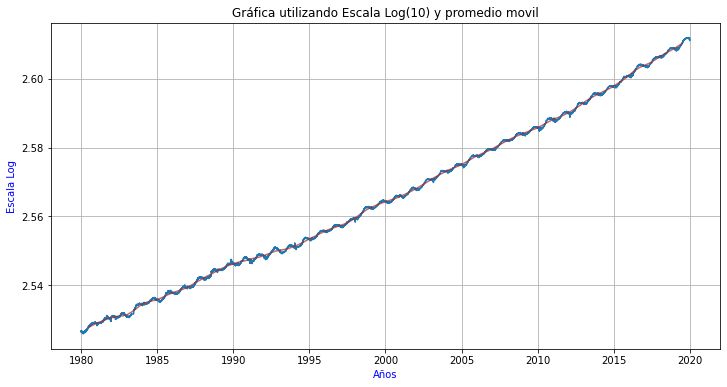

In [291]:
#Como no es estacionaria cambialos la escala
ts_test_log = np.log10(ts_test)
moving_avg = ts_test_log.rolling(365,center=True).mean()
plt.plot(ts_test_log)
plt.plot(moving_avg, color = 'brown',alpha=0.7)
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Log(10) y promedio movil')
plt.grid()
plt.show();

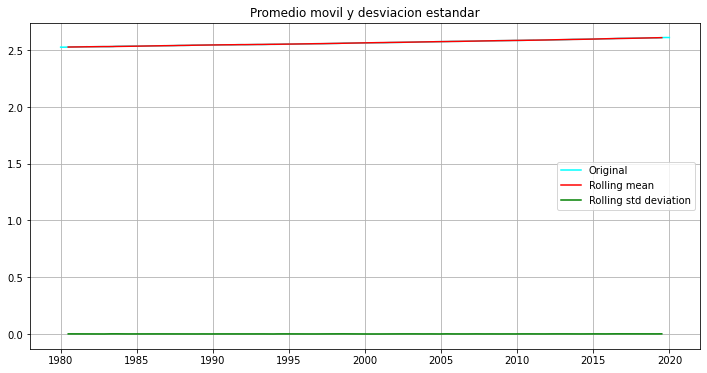

Resultados de la prueba de Dickey-Fuller: 
Test Statistic                    0.538071
p-value                           0.985985
#Lags Used                       42.000000
Number of Observatons Used    14567.000000
Critical Value(1%)               -3.430799
Critical Value(5%)               -2.861738
Critical Value(10%)              -2.566876
dtype: float64


In [292]:
test_stationarity(ts_test_log['CO2'])

No es estacionaria pero pasamos al siguiente punto

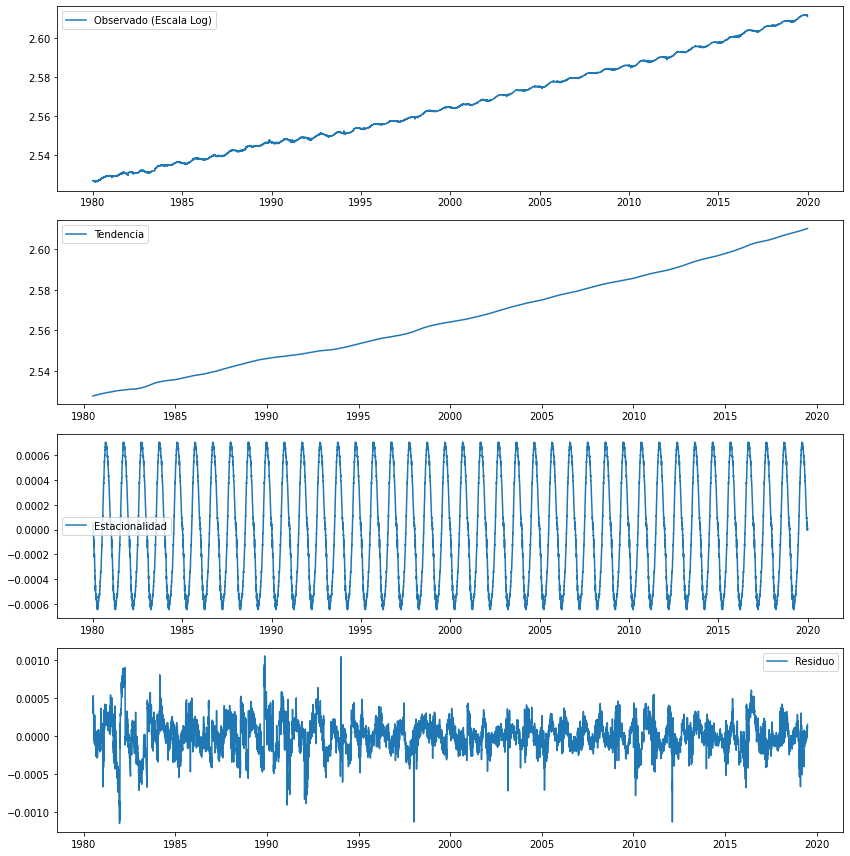

In [293]:
# Método de descomposición usando la biblioteca statsmodels.tsa

decomposition = sm.tsa.seasonal_decompose(ts_test_log.interpolate(),
                                          model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_log, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

Podemos ver que la tendencia del CO2 va en un aumento constante y de forma relativamente rapida, la dependencia con las estaciones no es muy clara, vemos que si tiene un ciclo por ejemplo baja en 5 ocasiones cada año y 5 veces aumenta tambien, las dos igualmente espaciadas. En cuanto al residuo me parece que cada vez disminuye la variabilidad de este pero un minimo. 


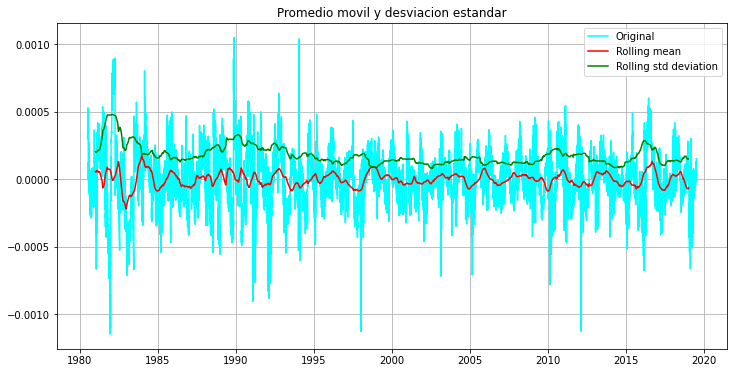

Resultados de la prueba de Dickey-Fuller: 
Test Statistic               -1.135572e+01
p-value                       9.746288e-21
#Lags Used                    2.800000e+01
Number of Observatons Used    1.421700e+04
Critical Value(1%)           -3.430810e+00
Critical Value(5%)           -2.861743e+00
Critical Value(10%)          -2.566878e+00
dtype: float64


In [294]:
ts_test_log_decompose = residue 
ts_test_log_decompose.dropna(inplace=True)
ts_test_log_decompose .head()
test_stationarity(ts_test_log_decompose['CO2'])

Define un nuevo dataframe con la diferencia entre la serie logaritmo original y el promedio móvil, y prueba después su estacionaridad.

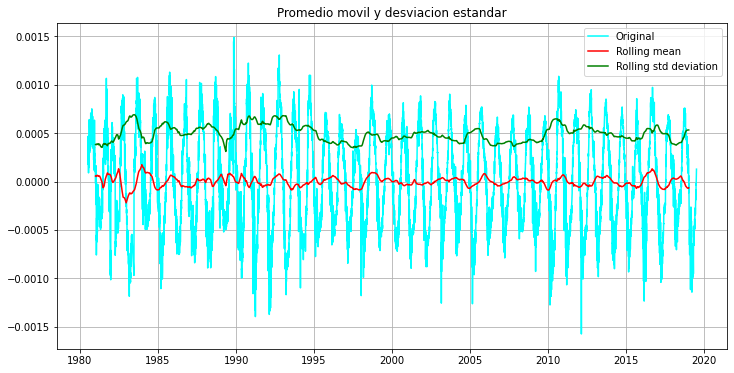

Resultados de la prueba de Dickey-Fuller: 
Test Statistic               -1.135538e+01
p-value                       9.763779e-21
#Lags Used                    4.200000e+01
Number of Observatons Used    1.420300e+04
Critical Value(1%)           -3.430811e+00
Critical Value(5%)           -2.861744e+00
Critical Value(10%)          -2.566878e+00
dtype: float64


In [295]:
ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
ts_test_log_moving_ave_diff.head()
#Hay NaN
ts_test_log_moving_ave_diff.dropna(inplace=True)
ts_test_log_moving_ave_diff.head()
#Corregido
test_stationarity(ts_test_log_moving_ave_diff['CO2'])


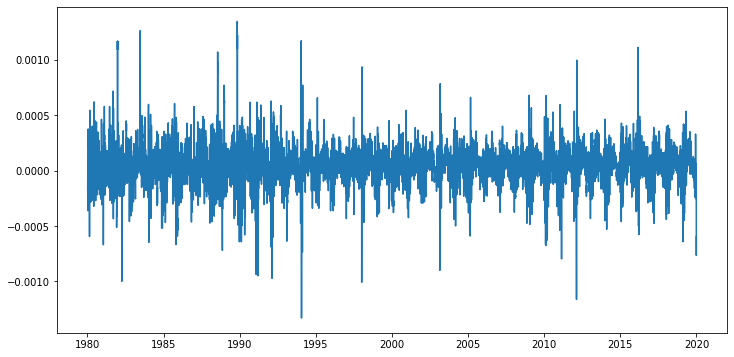

In [296]:
# Diferenciamos usando la función df.shift()
ts_test_log_diff = ts_test_log - ts_test_log.shift(periods=7)
ts_test_log_diff .dropna(inplace=True)
plt.plot(ts_test_log_diff);


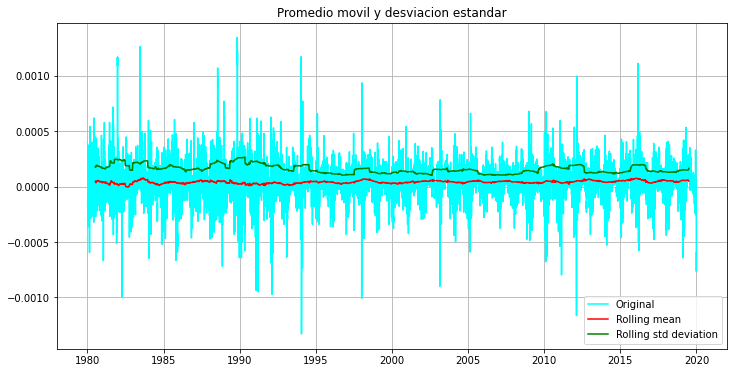

Resultados de la prueba de Dickey-Fuller: 
Test Statistic               -1.171651e+01
p-value                       1.446943e-21
#Lags Used                    4.200000e+01
Number of Observatons Used    1.456000e+04
Critical Value(1%)           -3.430799e+00
Critical Value(5%)           -2.861739e+00
Critical Value(10%)          -2.566876e+00
dtype: float64


In [297]:
test_stationarity(ts_test_log_diff['CO2'])

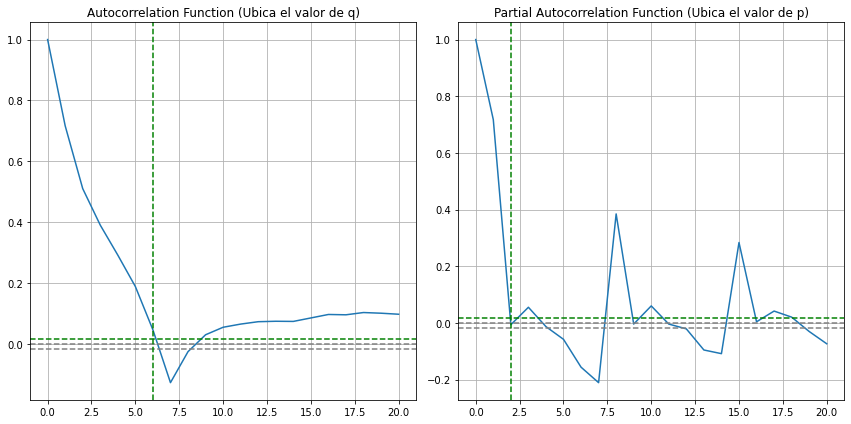

In [298]:
# Aplicamos ARIMA

lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias

plt.axvline(x=6, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

q=6 y p=2

##Modelo AR (Auto-Regresion)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                  D.CO2   No. Observations:                14609
Model:                 ARIMA(2, 1, 0)   Log Likelihood              116098.859
Method:                       css-mle   S.D. of innovations              0.000
Date:                Wed, 24 Feb 2021   AIC                        -232189.718
Time:                        23:41:24   BIC                        -232159.360
Sample:                    01-02-1980   HQIC                       -232179.632
                         - 12-31-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.788e-06   5.33e-07     10.851      0.000    4.74e-06    6.83e-06
ar.L1.D.CO2    -0.1522      0.008    -18.682      0.000      -0.168      -0.136
ar.L2.D.CO2    -0.1753      0.008    -21.511    

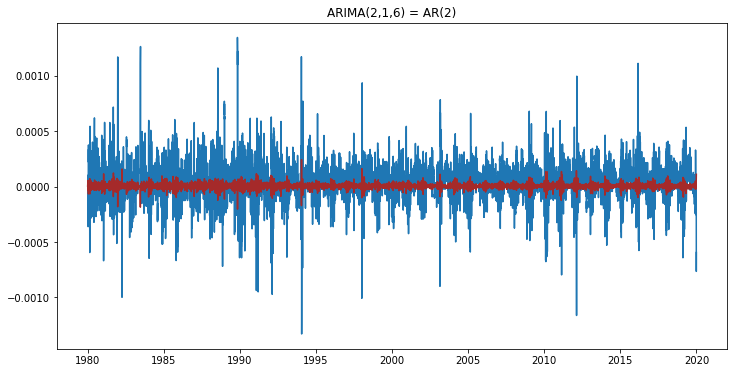

In [299]:
# Modelo AR(p): (p,d,q) = (2,1,6) 
model = ARIMA(ts_test_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,6) = AR(2)')
print(results_AR.summary())

In [300]:
AIC_AR= -232189.718 #-232189.718

##Modelo MA (Promedio movil)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                  D.CO2   No. Observations:                14609
Model:                 ARIMA(0, 1, 6)   Log Likelihood              115820.123
Method:                       css-mle   S.D. of innovations              0.000
Date:                Wed, 24 Feb 2021   AIC                        -231624.247
Time:                        23:41:27   BIC                        -231563.532
Sample:                    01-02-1980   HQIC                       -231604.076
                         - 12-31-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.815e-06   2.44e-07     23.850      0.000    5.34e-06    6.29e-06
ma.L1.D.CO2    -0.1786      0.009    -20.393      0.000      -0.196      -0.161
ma.L2.D.CO2    -0.2081      0.008    -24.684    

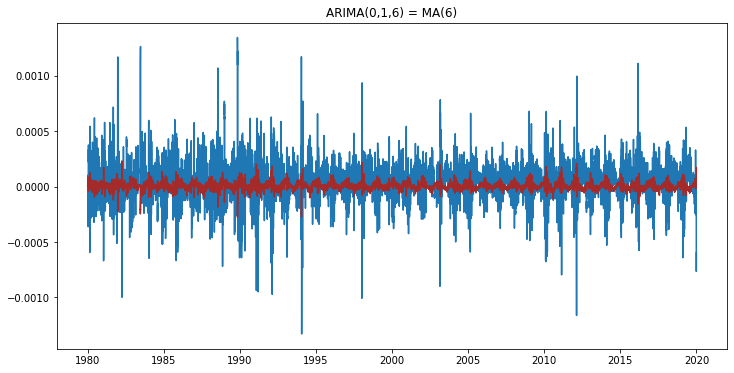

In [301]:
# Modelo MA(q): (p,d,q) = (2,1,6) 
model = ARIMA(ts_test_log, order=(0,1,6), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,6) = MA(6)')
print(results_MA.summary())

In [302]:
AIC_MA=-231624.247 

##Modelo ARIMA

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


                             ARIMA Model Results                              
Dep. Variable:                  D.CO2   No. Observations:                14609
Model:                 ARIMA(2, 1, 6)   Log Likelihood              116209.927
Method:                       css-mle   S.D. of innovations              0.000
Date:                Wed, 24 Feb 2021   AIC                        -232399.855
Time:                        23:41:41   BIC                        -232323.961
Sample:                    01-02-1980   HQIC                       -232374.642
                         - 12-31-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.795e-06   4.18e-07     13.861      0.000    4.98e-06    6.61e-06
ar.L1.D.CO2     0.3648        nan        nan        nan         nan         nan
ar.L2.D.CO2    -0.6854      0.094     -7.319    

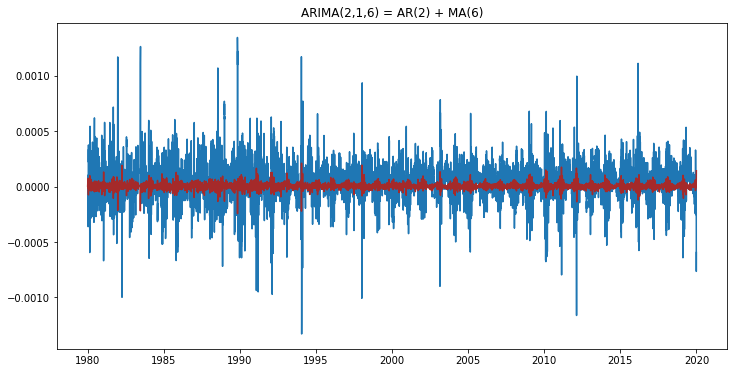

In [303]:
# Modelo ARIMA(p): (p,d,q) = (2,1,6) 
model = ARIMA(ts_test_log, order=(2,1,6), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,6) = AR(2) + MA(6)')
print(results_ARIMA.summary())

In [304]:
AIC_ARIMA= -232399.855

In [305]:
print('AIC_AR: ',AIC_AR,'AIC_MA: ',AIC_MA,'AIC_ARIMA: ',AIC_ARIMA)

AIC_AR:  -232189.718 AIC_MA:  -231624.247 AIC_ARIMA:  -232399.855


El mejor modelo resulto ser 
ARIMA (2,1,6) 

##Contrasta la serie observada de concentraciones de CO2 contra la construida por el modelo ARIMA.

In [306]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Fecha
1980-01-02    0.000006
1980-01-03    0.000010
1980-01-04    0.000026
1980-01-05    0.000032
1980-01-06    0.000022
dtype: float64

In [307]:
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions_ARIMA_log = pd.Series(ts_test_log['CO2'], index = ts_test_log.index)

predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
print('Ts_test:')
print(ts_test_log.head())
print('Predictions_Arima_log')
print(predictions_ARIMA_log.head())
print(predictions_ARIMA_log.tail())


Ts_test:
                 CO2
Fecha               
1980-01-01  2.526727
1980-01-02  2.526701
1980-01-03  2.526611
1980-01-04  2.526585
1980-01-05  2.526598
Predictions_Arima_log
Fecha
1980-01-01         NaN
1980-01-02    2.526707
1980-01-03    2.526621
1980-01-04    2.526611
1980-01-05    2.526630
dtype: float64
Fecha
2019-12-27    2.611791
2019-12-28    2.611741
2019-12-29    2.611438
2019-12-30    2.611184
2019-12-31    2.611409
dtype: float64


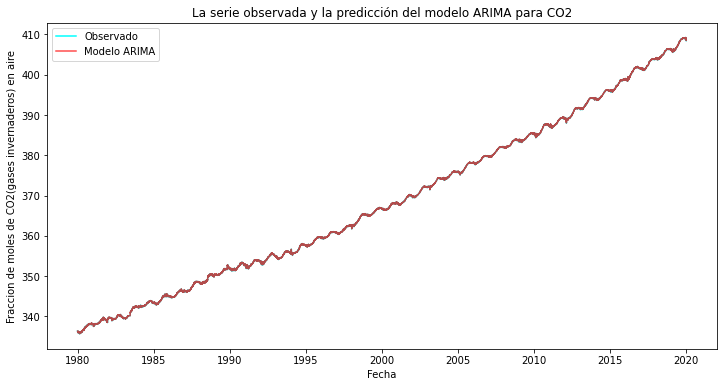

In [308]:
# Regresamos a la escala de Temperatura original 
predictions_ARIMA = 10**(predictions_ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test, label='Observado',color='cyan');
plt.plot(predictions_ARIMA, label='Modelo ARIMA',color='red',alpha=0.7);
plt.xlabel('Fecha')
plt.ylabel('Fraccion de moles de CO2(gases invernaderos) en aire')
#Si mal no entiendo esto es lo que dice 
#value:long_name : measured_mole_fraction_of_trace_gas_in_dry_air
# value:units : micromol mol-1
# value:comment : Mole fraction reported in units of micromol mol-1 
#(10-6 mol per mol of dry air); abbreviated as ppm (parts per million).
plt.title('La serie observada y la predicción del modelo ARIMA para CO2')
plt.legend(loc='best');

In [309]:
# Calculamos el RMSE (Root Mean Square Error 
#- Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_test['CO2'])**2))
print('RMSE:', RMSE)

RMSE: 0.018899244271053547


Graficamos solo los ultimos 5 años de la Serie de CO2 y el modelo ARIMA para ver mas a detalles el modelo.

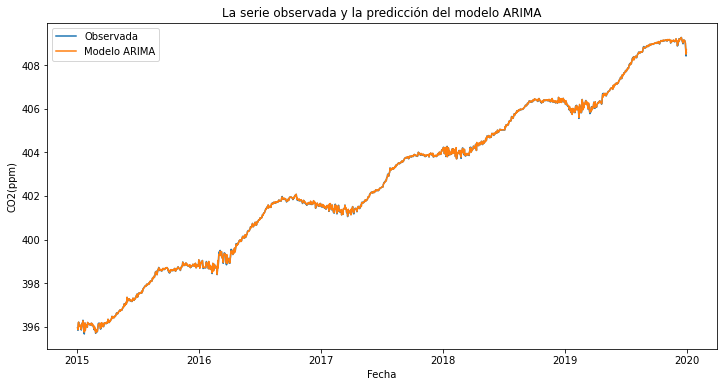

In [310]:
ts_test_last = ts_test.tail(1825)
predictions_ARIMA_last = predictions_ARIMA.tail(1825)
plt.plot(ts_test_last, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('CO2(ppm)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');

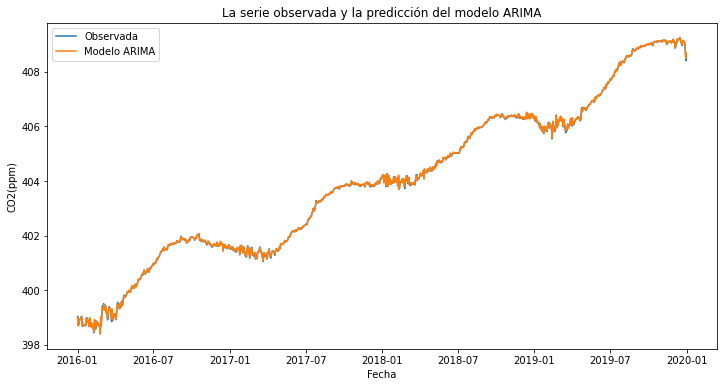

In [312]:
ts_test_last = ts_test.loc['2016-01-01':'2019-12-31']
predictions_ARIMA_last = predictions_ARIMA.loc['2016-01-01':'2019-12-31']
plt.plot(ts_test_last, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('CO2(ppm)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');